In [1]:
import os
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import numpy as np
import json

from os import getcwd
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.model_selection import GridSearchCV

from IPython.display import Image
from IPython.core.display import HTML 
from IPython.display import clear_output
%matplotlib inline    

data_dir = os.path.join(getcwd(), 'Corpus')
data_dir

'/home/acer/Documents/PythonProjects/SentimentMining/Corpus'

In [2]:
# saving current dataframe into csv
file_name = os.path.join(data_dir, "YelpReview_SG_new.json")
if not os.path.exists(file_name):
    SG_DF.to_json(file_name)
    print("File saved:\n{}".format(file_name))
else:
    SG_DF = pd.read_json(file_name, encoding='iso-8859-1') 
    print("File loaded:\n{}".format(file_name))

File loaded:
/home/acer/Documents/PythonProjects/SentimentMining/Corpus/YelpReview_SG_new.json


In [3]:
SG_DF.sample(n=5)

,Unnamed: 0,biz_id,country,friend_count,latitude,listed_category,longitude,overall_review,pred_sentiment,restaurant_address,restaurant_area,restaurant_name,review_count,review_date,sentitment,url,user_location,user_overall_rating,user_review,username
1088,1088,n-Pgwot9rVt7o5Nz3ChpuQ,Singapore,2983,1.315372,"Cafes, Pakistani, Indian",103.895449,7 reviews,1,"970 Geylang Rd, Singapore 423492",Joo Chiat,Traditional Haig Road Putu Piring,423,21/2/2017,1,https://www.yelp.com/biz/Traditional-Haig-Road...,"Edinburgh, United Kingdom",5,So I bookmarked this place when I was last in ...,Chantelle T.
640,640,t88UJ1i5c2HxbWQTV440mg,Singapore,0,1.296448,French,103.853731,28 reviews,1,"2 Stamford Road, Singapore 178882",Bras Brasah,Jaan,11,17/4/2013,-1,https://www.yelp.com/biz/Jaan-Singapore,"Houston, TX",3,Interesting but felt chef was trying to hard. ...,Brian H.
558,558,j_aIYB4uGOR45jAXivFNZQ,Singapore,145,1.305307,"Chinese, Noodles",103.862343,72 reviews,1,"466 Crawford Lane, Singapore 190465",Lavender,Tai Wah Pork Noodle,88,28/8/2014,1,https://www.yelp.com/biz/Hill-Street-Tai-Hwa-P...,"Bukit Timah, Singapore, Singapore",5,Definitely one of the best Mee Pok I have tast...,Jahan L.
282,282,b1ytpJcakiLtlpGkvxal-Q,Singapore,276,1.304335,Chinese,103.836174,17 reviews,1,"290 Orchard Road, Singapore 238859",Orchard,Crystal Jade Golden Palace,178,29/1/2015,1,https://www.yelp.com/biz/Crystal-Jade-Golden-P...,"Singapore, Singapore",4,It has been a few years since I revisited this...,Keira H.
456,456,cMZ7ZjrrnRxt2InvCxmNrA,Singapore,35,1.296551,"Bars, Italian",103.855047,14 reviews,1,"36 Purvis St, Singapore 188613","Bugis, Bras Brasah, City Hall",Garibaldi,50,4/11/2015,1,https://www.yelp.com/biz/Garibaldi-Singapore,"Singapore, Singapore",4,I went there during the Restaurant Week on 1 N...,Ivy C.


In [27]:
# convert all documents into tokens using Spacy
nlp = spacy.load('en')
stopWords = ["place", "just", "add", "big", "want", "pax", "quit", "everyone", "aaa", "aaaaammaz", "come", "ask"]

def process_text(doc1):
    doc1 = doc1.lower()
    doc1 = nlp(doc1)    
    doc1 = [token for token in doc1 if token.is_alpha]
    doc1 = [token for token in doc1 if not token.is_stop]
    doc1 = [token for token in doc1 if not token.text in stopWords]
    doc1 = [token for token in doc1 if not token.is_punct]
    doc1 = [token for token in doc1 if not token.is_space]
    doc1 = [token.lemma_ for token in doc1]
    doc1 = [token for token in doc1 if len(token) >= 3]
    doc1 = " ".join(doc1)
    return doc1.replace(".", " ")
   
clean_docs = []
for idx, row in SG_DF.iterrows():
    doc = process_text(row['user_review'])
    clean_docs.append(doc)
    clear_output(wait=True)
    print("Process: {}/{}".format(len(clean_docs), len(SG_DF)))

# # Test use
# doc = "This is a test text, good place, just eat."
# process_text(doc)

Process: 1243/1243


In [67]:
# convert document to vector, either as a unigram or ngram
vectorizer_unigram = CountVectorizer(analyzer='word', stop_words='english').fit(clean_docs)
vectorizer_ngram = CountVectorizer(analyzer='word', ngram_range=(1,3), stop_words='english').fit(clean_docs)

In [68]:
# Number of vocabulary in CountVectorizer
print("Unigram vocab size: {}".format(len(vectorizer_unigram.vocabulary_)))
print("N-gram vocab size: {}".format(len(vectorizer_ngram.vocabulary_)))
# vectorizer.vocabulary_

Unigram vocab size: 8449
N-gram vocab size: 152171


In [76]:
# Transform all documents into vectors
X = vectorizer_ngram.transform(SG_DF['user_review'])
Y = SG_DF['sentitment']

print("X: {}".format(X.shape))
print("Y: {}".format(Y.shape))

X: (1243, 152171)
Y: (1243,)


<h3>Multinomial Naive Bayes</h3>
Training a Multinomial Naive Bayes model to classify user sentiment value. 

Naive bayes is a classifier which is based on Bayes theorem. It uses words proabilities occuring on one after another and assume conditional independence.

**Multinomial NB**, is a variation takes into account the number of occurrences of term t in training document, including multiple occurrences.

Reference:  
[http://blog.datumbox.com/machine-learning-tutorial-the-naive-bayes-text-classifier/](http://blog.datumbox.com/machine-learning-tutorial-the-naive-bayes-text-classifier/)  
[https://medium.com/@theflyingmantis/text-classification-in-nlp-naive-bayes-a606bf419f8c](https://medium.com/@theflyingmantis/text-classification-in-nlp-naive-bayes-a606bf419f8c)

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [78]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print("Train size: {}".format(X_train.shape))
print("Test size: {}".format(X_test.shape))

Train size: (870, 152171)
Test size: (373, 152171)


In [79]:
# nb_model = MultinomialNB()
# nb_model.fit(X_train, Y_train)

# searching for best parameter using GridSearch
param_grid = {"alpha": [0.5, 0.8, 1]}
nb_model = MultinomialNB()
grid = GridSearchCV(estimator=nb_model, param_grid=param_grid, n_jobs=-1)
grid.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.5, 0.8, 1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [45]:
#ALthough grid search find the best value for alpha=0.5, when alpha=1 have higher F1 score
print(grid.best_score_)
print(grid.best_params_)

0.7862068965517242
{'alpha': 0.5}


When alpha = 0.5 <br>
TP: 80 <br>
FP: 22 <br>
FN: 8 <br>
Precision: 0.784 <br>
Recall: 0.909 <br>
F1: 0.842 <br>

In [80]:
nb_model = MultinomialNB(alpha=1)
nb_model.fit(X_train, Y_train)

nb_train_preds = nb_model.predict(X_train)
preds = nb_model.predict(X_test)
# print(preds)

confm = pd.crosstab( pd.Series(Y_test), pd.Series(preds), rownames= ['actuals'], colnames=['pred'], margins=True)
confm

pred,-1,1,All
actuals,,,
-1,1,24,25
1,0,88,88
All,1,112,113


In [81]:
print("TP: {}".format(confm[1][1]))
print("FP: {}".format(confm[1][-1]))
print("FN: {}".format(confm[-1][1]))
print("TN: {}".format(confm[-1][-1]))
print()

precision = (confm[1][1]) / (confm[1][1] + (confm[1][-1]))
print ("Precision: {}".format(str(round(precision, 3))))

recall = (confm[1][1]) / (confm[1][1] + (confm[-1][1]))
print ("Recall: {}".format(str(round(recall, 3))))

specificity = (confm[-1][-1] / (confm[-1][-1] + confm[1][-1]))
print ("Specificity: {}".format(str(round(specificity, 3))))

f1 = 2 * ((precision * recall) / (precision + recall))
print("F1: {}".format(str(round(f1, 3))))

TP: 88
FP: 24
FN: 0
TN: 1

Precision: 0.786
Recall: 1.0
Specificity: 0.04
F1: 0.88


We encounter a very small value in specificity, this might be due to inbalance dataset. We will verify this later in the notebook.

<h2>NB - Comparing unigram and n-gram results</h2>
<h3>Unigram results</h3>  
TP: 80  
FP: 23  
FN: 8  
TN: 2  

Precision: 0.777  
Recall: 0.909  
Specificity: 0.08  
F1: 0.838  

<h3>N-gram results</h3>  
TP: 88  
FP: 24  
FN: 0  
TN: 1  

Precision: 0.786  
Recall: 1.0  
Specificity: 0.04  
F1: 0.88 

Because of NB uses conditional independent, ngrams tokens captures more useful sequences of words that helps in estimating sentiment. Example negation of sentiment cannot be capture by unigram token.  
("taste", "not", "good")  
("taste not", "not good")  

In [56]:
def feature_words(vectorizer, model, n=10):
    feature_names = vectorizer.get_feature_names()
    sorted_coef = sorted(zip(model.coef_[0], feature_names), key=lambda k:k[0], reverse=True)
    return [w[1] for w in sorted_coef[:n]]

# Top 10 feature words using Naive Bayes Model
feature_words(vectorizer, nb_model)

['food',
 'good',
 'like',
 'restaurant',
 'singapore',
 'dish',
 'service',
 'great',
 'place',
 'best']

In [86]:
def least_feature_words(vectorizer, model, n=10):
    feature_names = vectorizer.get_feature_names()
    sorted_coef = sorted(zip(model.coef_[0], feature_names), key=lambda k:k[0], reverse=False)
    return [w[1] for w in sorted_coef[:n]]

least_feature_words(vectorizer, nb_model)

['aaaaammaz',
 'abalone',
 'abbey',
 'abd',
 'abierta',
 'abroad',
 'abs',
 'absolutely',
 'abstract',
 'absurdly']

<h3>Classification using SVM</h3>
Training a SVM model to classify user sentiment value.  

![image1.png](https://66.media.tumblr.com/ff709fe1c77091952fb3e3e6af91e302/tumblr_inline_o9aa8dYRkB1u37g00_540.png)

Unlike to NB which uses words probablitlies, SVM uses vector space for classification. SVM uses support vectors which are data points closest to the hyperplane to identify the best separation on different classes. When there is no clear hyperplane to separate classes. SVM "transform" data point to higher dimensions to find the best separation.  
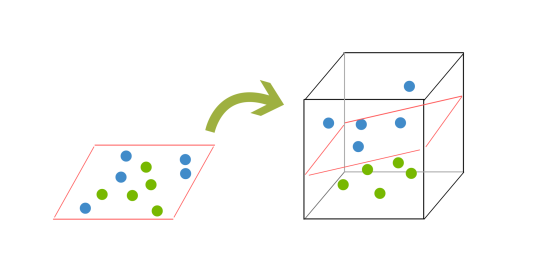

References:  
[https://www.kdnuggets.com/2016/07/support-vector-machines-simple-explanation.html](https://www.kdnuggets.com/2016/07/support-vector-machines-simple-explanation.html)

In [82]:
# Grid search
param_grid = {"C": [0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.6, 0.9, 1],
             "loss": ["hinge", "squared_hinge"],
             "multi_class": ['ovr', 'crammer_singer']}
svm_model = svm.LinearSVC(random_state=42)
grid = GridSearchCV(estimator=svm_model, param_grid=param_grid, n_jobs=-1)
grid.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.6, 0.9, 1], 'loss': ['hinge', 'squared_hinge'], 'multi_class': ['ovr', 'crammer_singer']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [171]:
print(grid.best_score_)
print(grid.best_params_)

0.7862068965517242
{'C': 0.1, 'loss': 'squared_hinge', 'multi_class': 'ovr'}


When C=0.002 it have the best performance although GridSearch reference to C=0.1

In [88]:
svm_model = svm.LinearSVC(C=0.002,random_state=42)
svm_model.fit(X_train, Y_train)

svm_train_preds = svm_model.predict(X_train)
preds = svm_model.predict(X_test)
# print(preds)

svm_confm = pd.crosstab( pd.Series(Y_test), pd.Series(preds), rownames= ['actuals'], colnames=['pred'],margins=True)
svm_confm

pred,-1,1,All
actuals,,,
-1,2,23,25
1,2,86,88
All,4,109,113


In [84]:
print("TP: {}".format(svm_confm[1][1]))
print("FP: {}".format(svm_confm[1][-1]))
print("FN: {}".format(svm_confm[-1][1]))
print("TN: {}".format(svm_confm[-1][-1]))
print()

precision = (svm_confm[1][1]) / (svm_confm[1][1] + (svm_confm[1][-1]))
print ("Precision: {}".format(str(round(precision, 3))))

recall = (svm_confm[1][1]) / (svm_confm[1][1] + (svm_confm[-1][1]))
print ("Recall: {}".format(str(round(recall, 3))))

specificity = (svm_confm[-1][-1] / (svm_confm[-1][-1] + svm_confm[1][-1]))
print ("Specificity: {}".format(str(round(specificity, 3))))

f1 = 2 * ((precision * recall) / (precision + recall))
print("F1: {}".format(str(round(f1, 3))))

TP: 86
FP: 23
FN: 2
TN: 2

Precision: 0.789
Recall: 0.977
Specificity: 0.08
F1: 0.873


Similar to NB we have very bad result on specificity. Will verify this at later part of this notebook.

<h2>SVM - Comparing unigram and n-gram results</h2>
<h3>Unigram results</h3>  
TP: 85  
FP: 23  
FN: 3  
TN: 2  

Precision: 0.787  
Recall: 0.966  
Specificity: 0.08  
F1: 0.867  

<h3>N-gram results</h3>  
TP: 86  
FP: 23  
FN: 2  
TN: 2  

Precision: 0.789  
Recall: 0.977  
Specificity: 0.08  
F1: 0.873 

SVM uses vectors space adding more collection of tokens does not improve performance as much as NB.

In [16]:
# Top 10 feature words using SVM model
feature_words(vectorizer, svm_model)

['best',
 'delicious',
 'great',
 'singapore',
 'amazing',
 'excellent',
 'line',
 'recommend',
 'service',
 'definitely']

<h3>Saving result to respective format</h3>

In [26]:
# Train score
print("Total records: {}".format(len(SG_DF)))

unique_categories = []
for idx, doc in SG_DF.iterrows():
    for cat in doc['listed_category'].split(','):        
        unique_categories.append(cat.strip())

unique_categories = set(unique_categories)
# print("unique_categories: {}".format(len(unique_categories)))
# print(unique_categories)
# print()

# Count the total number comments on each categories.
# Note that categories will overlap.
rest_category = dict.fromkeys(unique_categories, 0)
for idx, doc in SG_DF.iterrows():
    for cat in doc['listed_category'].split(','):
        cat = cat.strip()
        rest_category[cat] += 1

rest_category = sorted(rest_category.items(), key=lambda k: k[1], reverse=True)
print(rest_category)
print()

# Extracting only Chinese, Asian Fusion, Noodles, Steakhouses categories
rest_categories = [rest[0] for rest in rest_category[:4]]
print(rest_categories)
print()

extract_SG_DF = {'Chinese': [], 'Asian Fusion':[], 'Noodles':[], 'Steakhouses':[]}

# Extracting only Train and Test records
Train_DF = [SG_DF.iloc[idx] for idx, label in Y_train.items()]
Train_DF = pd.DataFrame(Train_DF)
Test_DF = [SG_DF.iloc[idx] for idx, label in Y_test.items()]
Test_DF = pd.DataFrame(Test_DF)

# placing predicted records back into dataframes
Train_DF['svm_train_preds'] = svm_train_preds
Train_DF['nb_train_preds'] = nb_train_preds

train_scored = {}
for cat in rest_categories:        
    extract_SG_DF[cat] = [row for idx, row in Train_DF.iterrows() if cat in row['listed_category']]
    extract_SG_DF[cat] = pd.DataFrame(extract_SG_DF[cat])
    
    # retrieve unique restaurant name
    rest_list = []
    unique_rest_name = set(extract_SG_DF[cat]['restaurant_name'])
    for name in unique_rest_name:        
        rest = {}
        rest['name'] = name        
        
        # retrieve reviews on each restaurant 
        review_list = []
        single_rest = extract_SG_DF[cat][extract_SG_DF[cat]['restaurant_name'] == name]                
        rest['nb_review'] = list(single_rest['overall_review'])[0]
        rest['nb_review'] = int(rest['nb_review'].split(' ')[0])
        for idx, row in single_rest.iterrows():            
            review = {}
            review['text'] = row['user_review']
            review['score'] = row['svm_train_preds'] #Change to either SVM or NB
            review_list.append(review)
        rest['reviews'] = review_list
        rest_list.append(rest)
    
    train_scored[cat] = rest_list

train_scored = pd.DataFrame.from_dict(train_scored, orient='index')
train_scored = train_scored.transpose()

print("Train Records: {}".format(len(train_scored)))
train_scored

Total records: 1243
[('Chinese', 267), ('Asian Fusion', 154), ('Noodles', 148), ('Steakhouses', 136), ('Singaporean', 125), ('French', 106), ('Indian', 102), ('Spanish', 79), ('Australian', 67), ('Japanese', 67), ('Food Stands', 56), ('Barbeque', 55), ('Thai', 53), ('Italian', 50), ('American (Traditional)', 48), ('Modern European', 47), ('Cocktail Bars', 46), ('Cantonese', 45), ('Dim Sum', 43), ('Tapas/Small Plates', 41), ('Street Vendors', 41), ('Bars', 40), ('Shanghainese', 31), ('Lounges', 28), ('Fondue', 28), ('Seafood', 25), ('Vegetarian', 25), ('Food', 21), ('Mediterranean', 20), ('Ramen', 13), ('Wine Bars', 13), ('Brasseries', 13), ('Breakfast & Brunch', 12), ('Szechuan', 12), ('Restaurants', 11), ('Gelato', 10), ('Ice Cream & Frozen Yogurt', 10), ('Pakistani', 7), ('Venues & Event Spaces', 7), ('Local Flavor', 7), ('Malaysian', 7), ('Nasi Lemak', 7), ('Cafes', 7), ('Imported Food', 6), ('Sushi Bars', 6), ('Farmers Market', 4), ('Mexican', 3), ('Soup', 2), ('Bakeries', 1)]

['C

,Noodles,Steakhouses,Chinese,Asian Fusion
0,"{'name': 'Xing Ji Rou Cuo Mian', 'reviews': [{...","{'name': 'Fat Cow', 'reviews': [{'score': 1, '...","{'name': 'Xing Ji Rou Cuo Mian', 'reviews': [{...","{'name': 'Waku Ghin', 'reviews': [{'score': 1,..."
1,{'name': 'Depot Road Zhen Shan Mei Claypot Lak...,"{'name': 'Burnt Ends', 'reviews': [{'score': 1...","{'name': 'Hup Hup Minced Meat Noodle', 'review...","{'name': 'Wild Rocket', 'reviews': [{'score': ..."
2,"{'name': 'Outram Park Fried Kway Teow', 'revie...","{'name': 'Gordon Grill', 'reviews': [{'score':...",{'name': 'Tiong Bahru Hainanese Boneless Chick...,"{'name': 'Akira Back', 'reviews': [{'score': 1..."
3,"{'name': 'Tai Wah Pork Noodle', 'reviews': [{'...","{'name': 'CUT', 'reviews': [{'score': 1, 'text...","{'name': 'Wah Kee Big Prawn Noodles', 'reviews...","{'name': 'Lao Fu Zi Fried Kway Teow', 'reviews..."
4,"{'name': 'Lor Mee 178', 'reviews': [{'score': ...",None,"{'name': 'Geylang Claypot Rice', 'reviews': [{...","{'name': 'Candlenut', 'reviews': [{'score': 1,..."
5,"{'name': 'Zhong Guo La Mian Xiao Long Bao', 'r...",None,"{'name': 'Jalan Sultan Prawn Mee', 'reviews': ...","{'name': 'True Blue Cuisine', 'reviews': [{'sc..."
6,None,None,"{'name': 'Min Jiang At One-North', 'reviews': ...","{'name': 'Empress', 'reviews': [{'score': 1, '..."
7,None,None,"{'name': 'Balestier Road Hoover Rojak', 'revie...","{'name': 'Mezza9', 'reviews': [{'score': 1, 't..."
8,None,None,"{'name': 'Tian Tian Hainanese Chicken Rice', '...","{'name': 'Labyrinth', 'reviews': [{'score': 1,..."
9,None,None,"{'name': 'Empress', 'reviews': [{'score': 1, '...","{'name': 'Yuan Chun Famous Lor Mee', 'reviews'..."


In [22]:
# saving train_score
file_name = os.path.join(data_dir, "svm_train_scored.csv")
train_scored.to_csv(file_name, sep='\t', encoding='iso-8859-1')
print("File saved. {}".format(file_name))

File saved. D:\Google Drive\NUS Masters\Sem2\Sentiment Mining\CA1\Corpus\svm_train_scored.csv


<h3> Verifying on poor performance in Specificity</h3>

We have found that dataset is skew towards positive sentiment and for 3 stars rating comments, many contain positive sentiment comments. This is further explored in *CA1_LabelData.ipynb*. To verifying if labeling 3 stars rating as negative are affecting Specificity score. 3 stars rating comments are filter and rebalance our positive and negative sentiment comments.

In [54]:
FILTERED_SG_DF = SG_DF[SG_DF['user_overall_rating'] != 3]
pred_rate3 = []

# filter alway rating 3
for idx, row in FILTERED_SG_DF.iterrows():
    score = row['user_overall_rating']
    if score <3:
        pred_rate3.append(-1)
    else:
        pred_rate3.append(1)

FILTERED_SG_DF['sentitment'] = pred_rate3

neg = len([i for i in pred_rate3 if i == -1])
pos = len([i for i in pred_rate3 if i == 1])

print("Total neg: {}".format(neg))
print("Total pos: {}".format(pos))

# Balancing positive and negative comments
pos_row = []
neg_row = []
for idx, row in FILTERED_SG_DF.iterrows():
    if row['sentitment'] == 1 and len(pos_row) < neg:
        pos_row.append(row)
    if row['sentitment'] == -1:
        neg_row.append(row)

FILTERED_SG_DF = pd.DataFrame(pos_row + neg_row)

# Transform all documents into vectors
X = vectorizer.transform(FILTERED_SG_DF['user_review'])
Y = FILTERED_SG_DF['sentitment']

# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print("Train size: {}".format(X_train.shape))
print("Test size: {}".format(X_test.shape))

c:\users\himur\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Total neg: 113
Total pos: 923
Train size: (158, 159745)
Test size: (68, 159745)


As we can see, there are 8x more positive comment than negative ones. We are going to rebalance them and remove 3 stars rating comments.

In [63]:
nb_model = MultinomialNB(alpha=1)
nb_model.fit(X_train, Y_train)

nb_train_preds = nb_model.predict(X_train)
preds = nb_model.predict(X_test)

confm = pd.crosstab(Y_test, preds, rownames= ['actuals'], colnames=['pred'], margins=True)
confm

pred,-1,1,All
actuals,,,
-1,29,7,36
1,2,30,32
All,31,37,68


In [64]:
print("TP: {}".format(confm[1][1]))
print("FP: {}".format(confm[1][-1]))
print("FN: {}".format(confm[-1][1]))
print("TN: {}".format(confm[-1][-1]))
print()

precision = (confm[1][1]) / (confm[1][1] + (confm[1][-1]))
print ("Precision: {}".format(str(round(precision, 3))))

recall = (confm[1][1]) / (confm[1][1] + (confm[-1][1]))
print ("Recall: {}".format(str(round(recall, 3))))

specificity = (confm[-1][-1] / (confm[-1][-1] + confm[1][-1]))
print ("Specificity: {}".format(str(round(specificity, 3))))

f1 = 2 * ((precision * recall) / (precision + recall))
print("F1: {}".format(str(round(f1, 3))))

TP: 30
FP: 7
FN: 2
TN: 29

Precision: 0.811
Recall: 0.938
Specificity: 0.806
F1: 0.87


After balancing the training and dataset, specificity improve significately. As for F1 score it only has a minor drop of 0.01. This shows that skewed dataset can greatly affect our model and ambiguity labels can affect our model too.